In [1]:
import pandas as pd
import re

def extract_links_from_text(column_value, is_chatbot=False):
    """Extract links from a text column, handling human and chatbot formats."""
    if pd.isna(column_value):
        return []
    if is_chatbot:
        return re.findall(r'Information taken from: (https?://[^\s]+)', column_value)
    return [link[0] or link[1] for link in re.findall(r'\[.*?\]\((.*?)\)|([^;\s]+)', column_value)]

# True Positives (TP): Links that are present in both human_links and chatbot_links. - Intersection count
# False Positives (FP): Links that are present in chatbot_links but not in human_links. - Extra links used by chatbot
# False Negatives (FN): Links that are present in human_links but not in chatbot_links. - Missing links used by human but not chatbot

def ture_positives(human_links, chatbot_links):
    """Calculate the number of true positives. - Intersection count"""
    return len(set(human_links) & set(chatbot_links))

def false_positives(human_links, chatbot_links):
    """Calculate the number of false positives. - Extra links used by chatbot"""
    return len(set(chatbot_links) - set(human_links))

def false_negatives(human_links, chatbot_links):
    """Calculate the number of false negatives. - Missing links used by human but not chatbot"""
    return len(set(human_links) - set(chatbot_links))

def recall(human_links, chatbot_links):
    """Calculate the recall of chatbot links w.r.t. human links."""
    tp = ture_positives(human_links, chatbot_links)
    fn = false_negatives(human_links, chatbot_links)
    return tp / (tp + fn) if tp + fn != 0 else 0.0

def precision(human_links, chatbot_links):
    """Calculate the precision of chatbot links w.r.t. human links."""
    tp = ture_positives(human_links, chatbot_links)
    fp = false_positives(human_links, chatbot_links)
    return tp / (tp + fp) if tp + fp != 0 else 0.0


def f1_score(human_links, chatbot_links):
    """Calculate the F1-score with special handling for no human links."""
    if not human_links:  # No links provided by humans
        return 1.0 if not chatbot_links else 0.0  # Perfect if chatbot also uses no links
    rec = recall(human_links, chatbot_links)
    prec = precision(human_links, chatbot_links)
    if rec + prec == 0:
        return 0.0
    return 2 * (prec * rec) / (prec + rec)

# Load datasets
csv_english = "../../data/short_dataset_en.csv"
csv_german = "../../data/short_dataset_de.csv"

df_en = pd.read_csv(csv_english)
df_de = pd.read_csv(csv_german)

# Process datasets
def process_dataset(df, human_col, chatbot_col):
    df['human_links'] = df[human_col].apply(extract_links_from_text)
    df['chatbot_links'] = df[chatbot_col].apply(lambda x: extract_links_from_text(x, is_chatbot=True))
    df['true_positive'] = df.apply(lambda row: ture_positives(row['human_links'], row['chatbot_links']), axis=1)
    df['false_positive'] = df.apply(lambda row: false_positives(row['human_links'], row['chatbot_links']), axis=1)
    df['false_negative'] = df.apply(lambda row: false_negatives(row['human_links'], row['chatbot_links']), axis=1)
    df['recall'] = df.apply(lambda row: recall(row['human_links'], row['chatbot_links']), axis=1)
    df['precision'] = df.apply(lambda row: precision(row['human_links'], row['chatbot_links']), axis=1)
    df['f1_score'] = df.apply(lambda row: f1_score(row['human_links'], row['chatbot_links']), axis=1)

process_dataset(df_en, 'human_answer_links_en', 'chatbot_context_en')
process_dataset(df_de, 'human_answer_links_de', 'chatbot_context_de')

# Save results
output_english = "../../testing/english_comparison_results_1.csv"
output_german = "../../testing/german_comparison_results_1.csv"

df_en.to_csv(output_english, index=False)
df_de.to_csv(output_german, index=False)

# Print summary
for lang, df in [('English', df_en), ('German', df_de)]:
    print(f"\n{lang} Dataset Metrics:")
    print(f"Average Recall: {df['recall'].mean():.3f}")
    print(f"Average Precision: {df['precision'].mean():.3f}")
    print(f"Macro level F1-Score: {df['f1_score'].mean():.3f}")
    # Micro level F1-Score potentially bad since oone cannot take into account when both uses no links which is a perfect case
    #print(f"Micro level F1-Score: {df['true_positive'].sum() / (df['true_positive'].sum() + 1/2 * (df['false_positive'].sum() + df['false_negative'].sum())):.3f}")
    # Chatbot 4-link limit
    # calculate the percentage of times the human uses more than 4 links
    print(f"Percentage of times human uses more than 4 links: {len(df[df['human_links'].apply(len) > 4]) / len(df) * 100:.2f}%")
print(f"Results saved to {output_english} and {output_german}")



English Dataset Metrics:
Average Recall: 0.202
Average Precision: 0.098
Macro level F1-Score: 0.186
Percentage of times human uses more than 4 links: 6.06%

German Dataset Metrics:
Average Recall: 0.169
Average Precision: 0.083
Macro level F1-Score: 0.195
Percentage of times human uses more than 4 links: 6.06%
Results saved to ../../testing/english_comparison_results_1.csv and ../../testing/german_comparison_results_1.csv


In [2]:
# Coverage / Link Count Statistics
# How many links does the chatbot produce vs. how many the human produces (on average)?
# Distribution of chatbot's link usage (fraction of answers with 0 links, 1 link, etc.)

def compute_coverage_stats(df, language):
    # Compute number of links
    df['num_human_links'] = df['human_links'].apply(len)
    df['num_chatbot_links'] = df['chatbot_links'].apply(len)
    
    # Average number of links
    avg_human_links = df['num_human_links'].mean()
    avg_chatbot_links = df['num_chatbot_links'].mean()
    
    # Fraction of chatbot answers with 0 links
    fraction_zero_chatbot = (df['num_chatbot_links'] == 0).mean()
    
    # Fraction of chatbot answers with N links (distribution)
    chatbot_link_distribution = df['num_chatbot_links'].value_counts(normalize=True).sort_index()
    
    print(f"*** {language} Coverage Statistics ***")
    print(f"Average # of human links:   {avg_human_links:.2f}")
    print(f"Average # of chatbot links: {avg_chatbot_links:.2f}")
    print(f"Fraction of chatbot answers with 0 links: {fraction_zero_chatbot:.2%}")
    print("Distribution of chatbot link usage (N links -> fraction):")
    for num_links, fraction in chatbot_link_distribution.items():
        print(f"  {num_links} -> {fraction:.2%}")
    print("")

# Then simply call the function for each dataset:
compute_coverage_stats(df_en, "English")
compute_coverage_stats(df_de, "German")


*** English Coverage Statistics ***
Average # of human links:   1.97
Average # of chatbot links: 2.64
Fraction of chatbot answers with 0 links: 33.33%
Distribution of chatbot link usage (N links -> fraction):
  0 -> 33.33%
  3 -> 3.03%
  4 -> 63.64%

*** German Coverage Statistics ***
Average # of human links:   1.97
Average # of chatbot links: 2.30
Fraction of chatbot answers with 0 links: 42.42%
Distribution of chatbot link usage (N links -> fraction):
  0 -> 42.42%
  4 -> 57.58%



English: Spearman correlation between F1 and context quality = 0.133, p-value = 0.4599
German:  Spearman correlation between F1 and context quality = 0.304, p-value = 0.0849


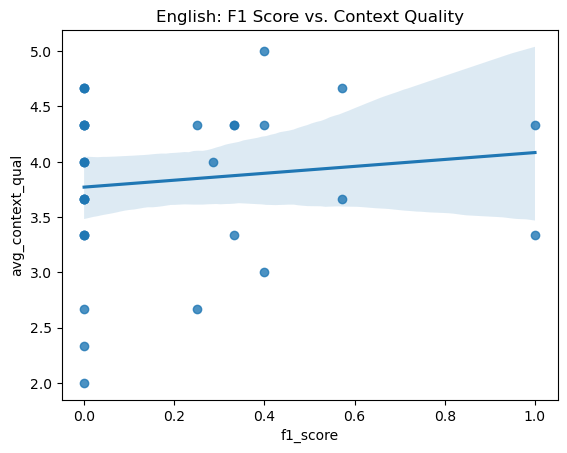

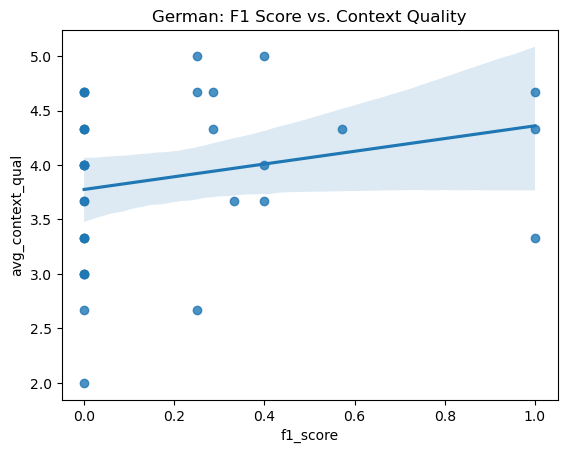

In [3]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1) Load your human evaluation CSV
# ------------------------------------------------------------------
eval_csv = "../../data/human_eval_avg.csv"  # Update with your actual path
eval_df = pd.read_csv(eval_csv)

# The evaluation CSV has columns like:
# ["question_number","qid","langq","avg_hallucination","avg_answer_acc","avg_user_sat",
#  "avg_coherence","avg_context_qual","avg_overall","overall_mean"]

# ------------------------------------------------------------------
# 2) Separate out English vs. German evaluations
# ------------------------------------------------------------------
eval_df_en = eval_df[eval_df['langq'] == 'en'].copy()
eval_df_de = eval_df[eval_df['langq'] == 'de'].copy()

# ------------------------------------------------------------------
# 3) Merge with your link-evaluation dataframes (df_en, df_de)
#    - 'qid' matches 'question_id_q'
#    - Make sure df_en/df_de each have a column 'question_id_q' to merge on.
# ------------------------------------------------------------------
df_en_merged = pd.merge(df_en, eval_df_en, left_on='question_id_q', right_on='qid', how='inner')
df_de_merged = pd.merge(df_de, eval_df_de, left_on='question_id_q', right_on='qid', how='inner')

# ------------------------------------------------------------------
# 4) Compute Spearman correlation between f1_score and avg_context_qual
# ------------------------------------------------------------------

spears_en, pval_en = spearmanr(df_en_merged['f1_score'], df_en_merged['avg_context_qual'])
spears_de, pval_de = spearmanr(df_de_merged['f1_score'], df_de_merged['avg_context_qual'])


print("English: Spearman correlation between F1 and context quality = "
      f"{spears_en:.3f}, p-value = {pval_en:.4f}")
print("German:  Spearman correlation between F1 and context quality = "
        f"{spears_de:.3f}, p-value = {pval_de:.4f}")
# ------------------------------------------------------------------
# 5) (Optional) Visualize with scatter + regression line
# ------------------------------------------------------------------
sns.regplot(x='f1_score', y='avg_context_qual', data=df_en_merged)
plt.title('English: F1 Score vs. Context Quality')
plt.show()

sns.regplot(x='f1_score', y='avg_context_qual', data=df_de_merged)
plt.title('German: F1 Score vs. Context Quality')
plt.show()


In [4]:
# calculate number of times human links == 0 and chatbot links == 0
num_both_zero_en = df_en[(df_en['human_links'].apply(len) == 0) & (df_en['chatbot_links'].apply(len) == 0)].shape[0]
num_both_zero_de = df_de[(df_de['human_links'].apply(len) == 0) & (df_de['chatbot_links'].apply(len) == 0)].shape[0]

print(f"Number of times both human links and chatbot links are zero in English dataset: {num_both_zero_en}")
print(f"Number of times both human links and chatbot links are zero in German dataset: {num_both_zero_de}")


Number of times both human links and chatbot links are zero in English dataset: 2
Number of times both human links and chatbot links are zero in German dataset: 3


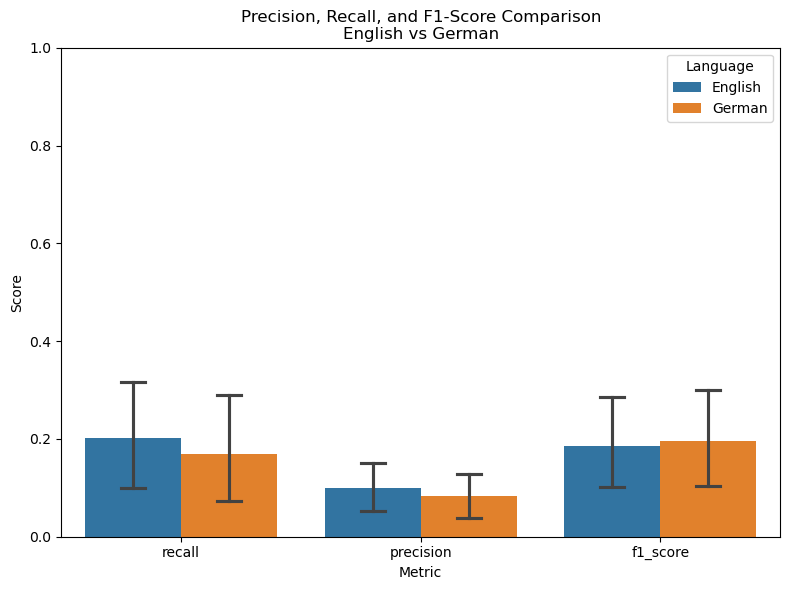

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a "long" format DataFrame for the English dataset
df_en_long = df_en[['recall', 'precision', 'f1_score']].melt(
    var_name='Metric', 
    value_name='Score'
)
df_en_long['Language'] = 'English'

# Create a "long" format DataFrame for the German dataset
df_de_long = df_de[['recall', 'precision', 'f1_score']].melt(
    var_name='Metric', 
    value_name='Score'
)
df_de_long['Language'] = 'German'

# Concatenate both DataFrames
df_metrics = pd.concat([df_en_long, df_de_long], ignore_index=True)

plt.figure(figsize=(8, 6))
sns.barplot(data=df_metrics, x='Metric', y='Score', hue='Language', capsize=.2)
plt.ylim(0, 1)
plt.title('Precision, Recall, and F1-Score Comparison\nEnglish vs German')
plt.ylabel('Score')
plt.legend(title='Language')

# # Optionally add the numerical values on top of each bar
# for container in plt.gca().containers:
#     plt.gca().bar_label(container, fmt='%.2f',padding=40,)

plt.tight_layout()
plt.show()


In [43]:
import pandas as pd
import re

def extract_links_from_human(column_value):
    """Extract links from the human_answer_links_xx column."""
    if pd.isna(column_value):
        return []
    # Match both markdown and plain links
    links = re.findall(r'\[.*?\]\((.*?)\)|([^;\s]+)', column_value)
    return [link[0] or link[1] for link in links]

def extract_links_from_chatbot(column_value):
    """Extract links from the chatbot_context_xx column."""
    if pd.isna(column_value):
        return []
    # Find the "Information taken from:" section and extract links
    matches = re.findall(r'Information taken from: (https?://[^\s]+)', column_value)
    return matches

def compare_links(human_links, chatbot_links):
    """Check if all human links are used by the chatbot.

    Args:
        human_links (list): A list of links provided by humans.
        chatbot_links (list): A list of links extracted from the chatbot's context.

    Returns:
        bool: True if all human links are used by the chatbot, or if human_links is empty,
              chatbot_links must also be empty.
    """
    if not human_links:
        return not chatbot_links
    return set(human_links).issubset(set(chatbot_links))

def partial_overlap_links(human_links, chatbot_links):
    """Check if at least one human link is used by the chatbot.

    Args:
        human_links (list): A list of links provided by humans.
        chatbot_links (list): A list of links extracted from the chatbot's context.

    Returns:
        bool: True if at least one human link is used by the chatbot, or if human_links is empty,
              chatbot_links must also be empty.
    """
    if not human_links:
        return not chatbot_links
    return bool(set(human_links) & set(chatbot_links))

# Load datasets
csv_english = "../../data/short_dataset_en.csv"
csv_german = "../../data/short_dataset_de.csv"

df_en = pd.read_csv(csv_english)
df_de = pd.read_csv(csv_german)

# Process datasets for English
df_en['human_answer_links_list_en'] = df_en['human_answer_links_en'].apply(extract_links_from_human)
df_en['chatbot_links_context_en'] = df_en['chatbot_context_en'].apply(extract_links_from_chatbot)
df_en['human_links_used'] = df_en.apply(
    lambda row: compare_links(row['human_answer_links_list_en'], row['chatbot_links_context_en']),
    axis=1
)
df_en['partial_overlap_links'] = df_en.apply(
    lambda row: partial_overlap_links(row['human_answer_links_list_en'], row['chatbot_links_context_en']),
    axis=1
)

# Process datasets for German
df_de['human_answer_links_list_de'] = df_de['human_answer_links_de'].apply(extract_links_from_human)
df_de['chatbot_links_context_de'] = df_de['chatbot_context_de'].apply(extract_links_from_chatbot)
df_de['human_links_used'] = df_de.apply(
    lambda row: compare_links(row['human_answer_links_list_de'], row['chatbot_links_context_de']),
    axis=1
)
df_de['partial_overlap_links'] = df_de.apply(
    lambda row: partial_overlap_links(row['human_answer_links_list_de'], row['chatbot_links_context_de']),
    axis=1
)

# Calculate and print the percentage of all human links used per dataset
percentage_all_en = (df_en['human_links_used'].mean() * 100) if not df_en.empty else 0
percentage_all_de = (df_de['human_links_used'].mean() * 100) if not df_de.empty else 0

print(f"\nPercentage of all human links used in the English dataset: {percentage_all_en:.2f}%")
print(f"Percentage of all human links used in the German dataset: {percentage_all_de:.2f}%")

# Calculate and print the percentage of min one human link used per dataset
percentage_one_en = (df_en['partial_overlap_links'].mean() * 100) if not df_en.empty else 0
percentage_one_de = (df_de['partial_overlap_links'].mean() * 100) if not df_de.empty else 0

print(f"\nPercentage of min one human link used in the English dataset: {percentage_one_en:.2f}%")
print(f"Percentage of min one human link used in the German dataset: {percentage_one_de:.2f}%")


# Calculate and print the average number of links used
avg_human_links_en = df_en['human_answer_links_list_en'].apply(len).mean() if not df_en.empty else 0
avg_chatbot_links_en = df_en['chatbot_links_context_en'].apply(len).mean() if not df_en.empty else 0
avg_human_links_de = df_de['human_answer_links_list_de'].apply(len).mean() if not df_de.empty else 0
avg_chatbot_links_de = df_de['chatbot_links_context_de'].apply(len).mean() if not df_de.empty else 0

print(f"\nAverage number of links used in the English dataset:\n  Human: {avg_human_links_en:.2f}\n  Chatbot: {avg_chatbot_links_en:.2f}")
print(f"Average number of links used in the German dataset:\n  Human: {avg_human_links_de:.2f}\n  Chatbot: {avg_chatbot_links_de:.2f}")

# Percentage of times the chatbot used no context links
no_links_chatbot_en_percentage = (df_en['chatbot_links_context_en'].apply(len) == 0).mean() * 100
no_links_chatbot_de_percentage = (df_de['chatbot_links_context_de'].apply(len) == 0).mean() * 100
print(f"\nPercentage of times the chatbot used no context links:\n  English: {no_links_chatbot_en_percentage:.2f}%\n  German: {no_links_chatbot_de_percentage:.2f}%")

# Percentage of times the human used no context links
no_links_human_en_percentage = (df_en['human_answer_links_list_en'].apply(len) == 0).mean() * 100
no_links_human_de_percentage = (df_de['human_answer_links_list_de'].apply(len) == 0).mean() * 100
print(f"\nPercentage of times the human used no context links:\n  English: {no_links_human_en_percentage:.2f}%\n  German: {no_links_human_de_percentage:.2f}%")

# # Print results in a readable format
# print("\nEnglish Dataset Results:")
# for index, row in df_en.iterrows():
#     print(f"Row {index + 1} - Human Links: {row['human_answer_links_list_en']}\nChatbot Links: {row['chatbot_links_context_en']}\nHuman Links Used: {row['human_links_used']}\nPartial Overlap Links: {row['partial_overlap_links']}\n")

# print("\nGerman Dataset Results:")
# for index, row in df_de.iterrows():
#     print(f"Row {index + 1} - Human Links: {row['human_answer_links_list_de']}\nChatbot Links: {row['chatbot_links_context_de']}\nHuman Links Used: {row['human_links_used']}\nPartial Overlap Links: {row['partial_overlap_links']}\n")

# Save results
output_english = "../../testing/english_comparison_results.csv"
output_german = "../../testing/german_comparison_results.csv"

df_en.to_csv(output_english, index=False)
df_de.to_csv(output_german, index=False)

print(f"Results saved to {output_english} and {output_german}")



Percentage of all human links used in the English dataset: 15.15%
Percentage of all human links used in the German dataset: 18.18%

Percentage of min one human link used in the English dataset: 39.39%
Percentage of min one human link used in the German dataset: 39.39%

Average number of links used in the English dataset:
  Human: 1.97
  Chatbot: 2.64
Average number of links used in the German dataset:
  Human: 1.97
  Chatbot: 2.30

Percentage of times the chatbot used no context links:
  English: 33.33%
  German: 42.42%

Percentage of times the human used no context links:
  English: 15.15%
  German: 15.15%
Results saved to ../../testing/english_comparison_results.csv and ../../testing/german_comparison_results.csv
